# data loading

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [12]:
def load_data(filename):
    data = pd.read_csv(filename, sep=',', parse_dates=[['<DATE>', '<TIME>']])
    data.columns = map(lambda x: x.replace('<', '').replace('>', '').lower(), data.columns)
    data = data.rename({'date_time': 'date', 'vol': 'volume'}, axis=1)
    data = data.set_index('date')
    return data

In [13]:
data = pd.concat([load_data(i) for i in 
                  ['GAZP_131101_151031.csv', 'GAZP_151101_171031.csv', 'GAZP_171101_191031.csv', 'GAZP_191101_211031.csv']])
data['return'] = (data['close'] - data.shift()['close']) / data.shift()['close']
data['ticker'] = 'GAZP'

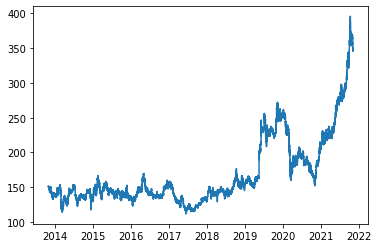

In [14]:
plt.plot(data['close'])

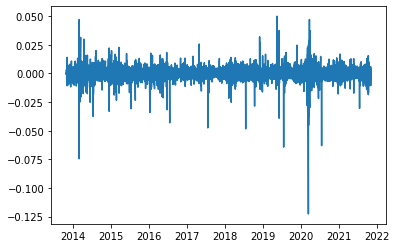

In [15]:
plt.plot(data['return'])

In [16]:
data_day = data.groupby(data.index.date).aggregate({
    'ticker': 'first',
    'return': lambda x: np.prod(x+1)-1, 
    'volume': 'sum', 
    'open': 'first', 
    'close': 'last'
    })
data_day['volatility'] = data.groupby(data.index.date).aggregate({'return': lambda x: np.sqrt((x**2).sum())})

<AxesSubplot:>

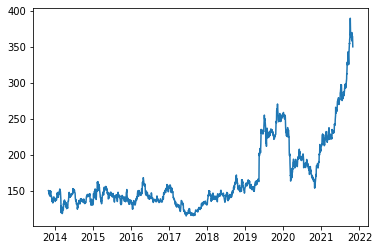

In [17]:
data_day['close'].plot()

<AxesSubplot:>

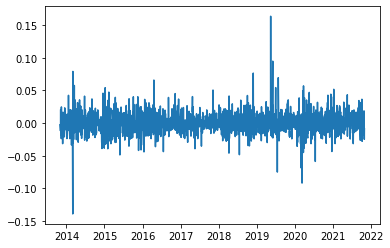

In [18]:
data_day['return'].plot()

<AxesSubplot:>

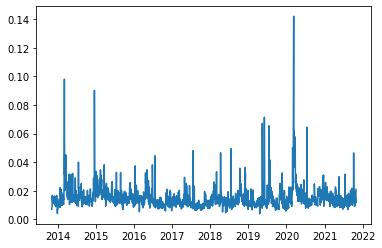

In [19]:
data_day['volatility'].plot()

<AxesSubplot:>

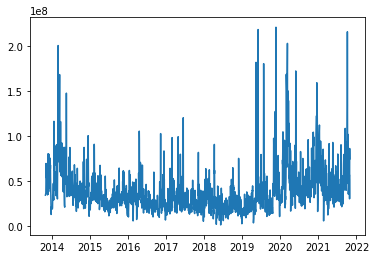

In [20]:
data_day['volume'].plot()

In [23]:
data_day = data_day[data_day.index < pd.to_datetime('2020-01-01')]

In [24]:
data_day

,ticker,return,volume,open,close,volatility
2013-11-01,GAZP,-0.002520,34581210,150.40,150.44,0.007140
2013-11-05,GAZP,-0.011699,36999370,150.84,148.68,0.009304
2013-11-06,GAZP,-0.009551,45785890,149.60,147.26,0.010938
2013-11-07,GAZP,0.020780,69806330,146.96,150.32,0.016914
2013-11-08,GAZP,-0.018427,54275270,149.43,147.55,0.014061
...,...,...,...,...,...,...
2019-12-24,GAZP,-0.000510,22751750,255.60,254.87,0.009343
2019-12-25,GAZP,-0.006356,12305460,254.90,253.25,0.005839
2019-12-26,GAZP,0.003356,10875580,253.45,254.10,0.005860
2019-12-27,GAZP,0.011846,24199940,254.33,257.11,0.007380


# data prep

In [309]:
LAGS_NUM = 30
SEQ_LENGTH = 10
VARS = ['volatility', 'return', 'volume']

In [310]:
data_prep = data_day.copy()

In [311]:
def create_lags(df, n=1):
    for col in df.columns:
        for i in range(1,n+1):
            df[f'{col}_lag_{i}'] = df[col].shift(i)
    return df

In [312]:
data_prep = create_lags(data_prep[VARS], LAGS_NUM)
target = pd.DataFrame({'volatility': data_prep['volatility'].shift(-1).iloc[:-1]})
data_prep = data_prep.iloc[:-1, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [313]:
data_prep

,volatility,return,volume,volatility_lag_1,volatility_lag_2,volatility_lag_3,volatility_lag_4,volatility_lag_5,volatility_lag_6,volatility_lag_7,volatility_lag_8,volatility_lag_9,volatility_lag_10,volatility_lag_11,volatility_lag_12,volatility_lag_13,volatility_lag_14,volatility_lag_15,volatility_lag_16,volatility_lag_17,volatility_lag_18,volatility_lag_19,volatility_lag_20,volatility_lag_21,volatility_lag_22,volatility_lag_23,volatility_lag_24,volatility_lag_25,volatility_lag_26,volatility_lag_27,volatility_lag_28,volatility_lag_29,volatility_lag_30,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,...,return_lag_21,return_lag_22,return_lag_23,return_lag_24,return_lag_25,return_lag_26,return_lag_27,return_lag_28,return_lag_29,return_lag_30,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,volume_lag_10,volume_lag_11,volume_lag_12,volume_lag_13,volume_lag_14,volume_lag_15,volume_lag_16,volume_lag_17,volume_lag_18,volume_lag_19,volume_lag_20,volume_lag_21,volume_lag_22,volume_lag_23,volume_lag_24,volume_lag_25,volume_lag_26,volume_lag_27,volume_lag_28,volume_lag_29,volume_lag_30
2013-11-01,0.007140,-0.002520,34581210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-05,0.009304,-0.011699,36999370,0.007140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002520,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34581210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-06,0.010938,-0.009551,45785890,0.009304,0.007140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011699,-0.002520,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36999370.0,34581210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-07,0.016914,0.020780,69806330,0.010938,0.009304,0.007140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009551,-0.011699,-0.002520,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45785890.0,36999370.0,34581210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-08,0.014061,-0.018427,54275270,0.016914,0.010938,0.009304,0.007140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020780,-0.009551,-0.011699,-2.519560e-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69806330.0,45785890.0,36999370.0,34581210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-24,0.017291,0.032769,47588820,0.012832,0.010044,0.006859,0.007799,0.008951,0.007578,0.008712,0.009891,0.009315,0.008165,0.009497,0.010567,0.010858,0.011334,0.015065,0.010623,0.007129,0.008753,0.007918,0.014658,0.011237,0.009008,0.007274,0.009645,0.008258,0.006431,0.010251,0.011874,0.009512,0.009682,0.003569,0.029842,0.002368,-2.220446e-16,1.317523e-03,7.522124e-03,-6.661338e-16,...,0.003206,-0.011547,-0.000217,-0.000477,-0.012593,-0.000514,-0.005535,0.010237,-0.001632,-0.009316,39572590.0,42863380.0,14398380.0,16558440

In [314]:
def train_val_test_split(df, validation_size=0.2, test_size=0.2, seq_length=30):
    train_size = 1 - validation_size - test_size
    df_len = df.shape[0] - seq_length

    train_len = round(df_len*train_size)
    val_len = round(df_len*validation_size)
    test_len = round(df_len*test_size)

    train_df = df.iloc[:train_len+seq_length]
    val_df = df.iloc[train_len:train_len+val_len+seq_length]
    test_df = df.iloc[train_len+val_len:]

    return train_df, val_df, test_df

In [315]:
train_data, val_data, test_data = train_val_test_split(data_prep[VARS], seq_length=SEQ_LENGTH)
train_target, val_target, test_target = train_val_test_split(target, seq_length=SEQ_LENGTH)

In [316]:
train_data_, val_data_, test_data_ = train_val_test_split(data_prep, seq_length=0)
train_data_ = train_data_.dropna()

In [317]:
class AdvancedScaler():
    def __init__(self):
        self.means = dict()
        self.stds = dict()

    def fit(self, df):
        for column in df.columns:
            self.means[column] = df[column].mean()
            self.stds[column] = df[column].std()
        return self
    
    def transform(self, df):
        df = df.copy()
        for column in set(df.columns) & self.means.keys():
            df[column] = (df[column] - self.means[column]) / self.stds[column]
        return df

    def transform_back(self, df):
        df = df.copy()
        for column in set(df.columns) & self.means.keys():
            df[column] = (df[column] * self.stds[column]) + self.means[column]
        return df

In [318]:
scaler = AdvancedScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)
full_data = scaler.transform(data_prep)[VARS]
train_target = scaler.transform(train_target)
val_target = scaler.transform(val_target)
test_target = scaler.transform(test_target)

In [319]:
target = scaler.transform(target)

# lstm model

In [320]:
BATCH_SIZE = 5000
TEST_BATCH_SIZE = 1000

In [321]:
#from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [322]:
#dataset = TimeSeriesDataSet(data_day, 'index_int', 'return', ['ticker'], allow_missing_timesteps=True, target_normalizer=None)

In [323]:
class TickerDataset(Dataset):
    def __init__(self, df_x, df_y, seq_length=0):
        self.seq_length = seq_length
        self.X = torch.tensor(df_x.values).float()
        self.y = torch.tensor(df_y.values).float().reshape(-1,1)

    def __len__(self):
        return self.X.shape[0] - self.seq_length

    def __getitem__(self, idx): 
        if isinstance(idx, int):
            if idx >= 0:
                df_idx = idx + self.seq_length
                return self.X[idx:df_idx+(self.seq_length==0), :], self.y[df_idx]
            else:
                df_idx = idx - self.seq_length
                return self.X[df_idx:idx+(self.seq_length==0), :], self.y[idx]
        elif isinstance(idx, slice):
            raise NotImplementedError('Slicing not supported')

In [324]:
dataset = TickerDataset(full_data, target, seq_length=SEQ_LENGTH)
train_dataset = TickerDataset(train_data, train_target, seq_length=SEQ_LENGTH)
val_dataset = TickerDataset(val_data, val_target, seq_length=SEQ_LENGTH)
test_dataset = TickerDataset(test_data, test_target, seq_length=SEQ_LENGTH)

In [325]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
full_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [326]:
class TestLSTM(nn.Module):
    def __init__(self, input_size, num_layers=1, hidden_size=100):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_size,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear1 = nn.Linear(in_features=self.hidden_size*self.num_layers, out_features=self.hidden_size*num_layers)
        self.linear2 = nn.Linear(in_features=self.hidden_size*self.num_layers, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.shape[0]

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()

        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.reshape(batch_size, -1)
        h = self.relu(hn)
        h = self.linear1(h)
        h = self.relu(h)
        h = self.linear2(h)
        return h

In [327]:
learning_rate = 0.0001

model = TestLSTM(input_size=dataset.X.shape[1], num_layers=1, hidden_size=256)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [328]:
class Trainer():
    def __init__(self, model, loss_function, optimizer):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        
        self.train_loss = np.array([])
        self.val_loss = np.array([])
    
    def _train(self, train_loader):
        num_batches = len(train_loader)
        total_loss = 0

        self.model.train()
        for X, y in train_loader:
            output = self.model(X)
            loss = self.loss_function(output, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / num_batches
        self.train_loss = np.append(self.train_loss, avg_loss)
    
    def _val(self, val_loader):
        num_batches = len(val_loader)
        total_loss = 0

        self.model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                output = self.model(X)
                #print(output)
                total_loss += self.loss_function(output, y).item()
        avg_loss = total_loss / num_batches
        self.val_loss = np.append(self.val_loss, avg_loss)

    def fit(self, train_loader, val_loader=None, epochs=100, verbose=False):
        for epoch in tqdm(range(epochs)):
            if verbose: print(f'{epoch} epoch:')
            self._train(train_loader)
            if verbose: print(f'train loss {self.train_loss[-1]}')
            if val_loader is not None:
                self._val(val_loader)
                if verbose: print(f'valid loss {self.val_loss[-1]}')

    def predict(self, data_loader):
        output = np.array([])
        self.model.eval()
        with torch.no_grad():
            for X, _ in data_loader:
                y_hat = model(X)
                output = np.concatenate((output, y_hat.flatten()), 0)
        return output

    def plot_loss(self):
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('train loss')
        ax1.plot(self.train_loss)

        ax2 = ax1.twinx()
        ax2.set_ylabel('val loss')
        ax2.plot(self.val_loss, color='orange')

        fig.tight_layout()
        return fig

In [329]:
def plot_preds(y_pred, y_true, splits=None):
    fig = plt.figure(figsize=(24,6))
    plt.plot(y_true)
    plt.plot(y_pred)
    if splits is not None:
        plt.axvline(x=splits[0], color='r', linestyle='--')
        plt.axvline(x=splits[1], color='r', linestyle='--')
    return fig

In [330]:
trainer = Trainer(model, loss_function, optimizer)

In [331]:
trainer.fit(train_loader, val_loader, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

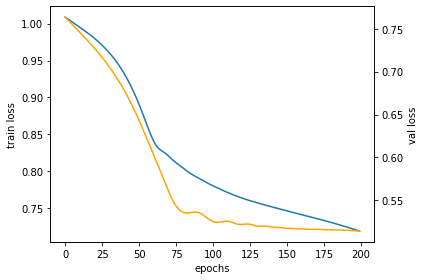

In [332]:
fig = trainer.plot_loss()

Text(0.5, 1.0, 'Predictions against target, full dataset')

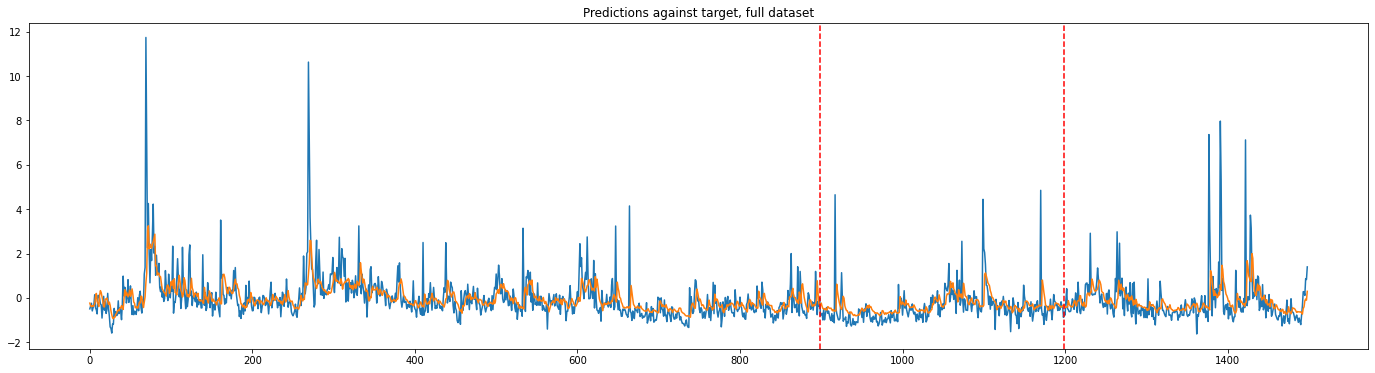

In [333]:
fig = plot_preds(trainer.predict(full_loader), dataset.y[SEQ_LENGTH:], splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

Text(0.5, 1.0, 'Predictions against target')

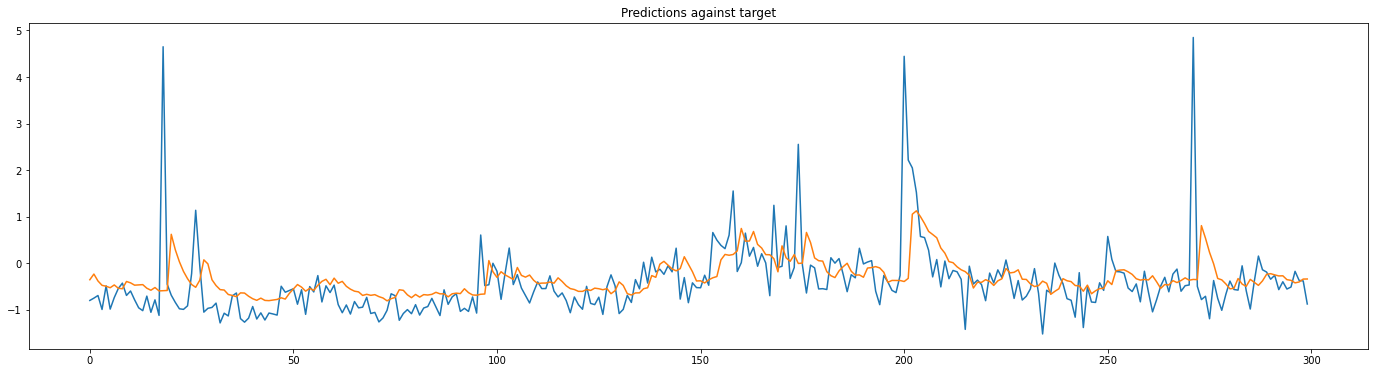

In [338]:
val_preds = trainer.predict(val_loader)
fig = plot_preds(val_preds, val_dataset.y[SEQ_LENGTH:])
plt.title('Predictions against target')

Text(0.5, 1.0, 'Predictions against previous value')

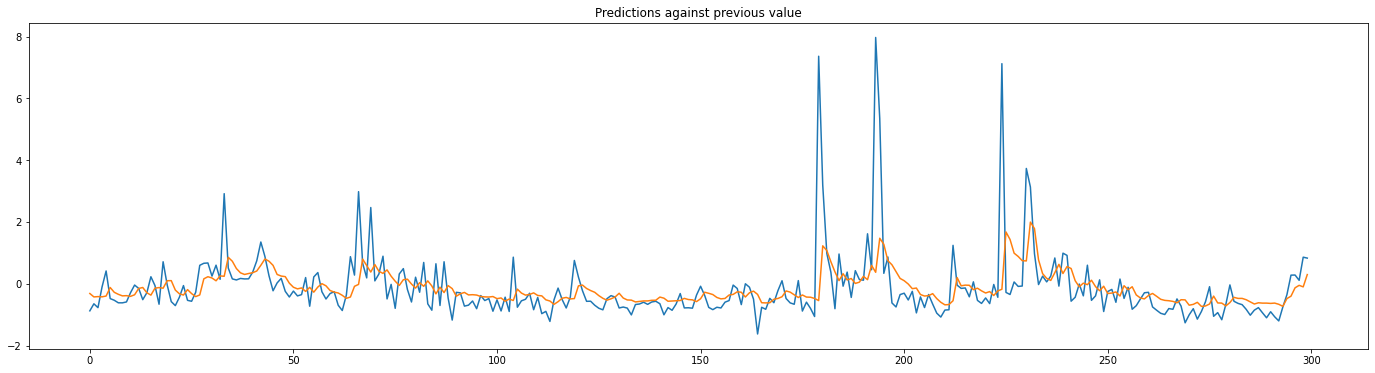

In [335]:
test_preds = trainer.predict(test_loader)
fig = plot_preds(test_preds, test_dataset.X[SEQ_LENGTH:, 0])
plt.title('Predictions against previous value')

In [336]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('Validation')
print('previous item baseline MSE |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_dataset.X[SEQ_LENGTH:, 0]))
print('prediction MSE             |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_preds))

Validation
previous item baseline MSE | 0.7287474
prediction MSE             | 0.5140222103030216


In [337]:
print('Test')
print('previous item baseline MSE |', mean_squared_error(test_dataset.y[SEQ_LENGTH:], test_dataset.X[SEQ_LENGTH:, 0]))
print('prediction MSE             |', mean_squared_error(test_dataset.y[SEQ_LENGTH:], test_preds))

Test
previous item baseline MSE | 1.4670317
prediction MSE             | 1.098894152332335


# deprecated

In [99]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            #print(output)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [100]:
for ix_epoch in range(200):
    if not (ix_epoch+1) % 10:
        print(f"Epoch {ix_epoch+1}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(val_loader, model, loss_function)

Train loss: 0.4187559187412262
Test loss: 1.9537044763565063


KeyboardInterrupt: ignored

In [ ]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [ ]:
prediction = predict(full_loader, model).numpy()

In [ ]:
prediction_test = predict(test_loader, model).numpy()

In [ ]:
plt.figure(figsize=(24,6))
plt.plot(dataset.y[SEQ_LENGTH:])
plt.plot(prediction)
#plt.plot(np.abs(prediction-dataset.y[SEQ_LENGTH:].numpy()))
plt.axvline(x=len(train_dataset), color='r', linestyle='--')
plt.axvline(x=len(train_dataset)+len(val_dataset), color='r', linestyle='--')

In [ ]:
plt.figure(figsize=(24,6))
plt.plot(test_dataset.y[SEQ_LENGTH:]) #blue
#plt.plot(test_dataset.X[:, 0]) #blue
plt.plot(prediction_test) # orange

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
print('previous item baseline MSE |', mean_squared_error(test_dataset.y[SEQ_LENGTH:], test_dataset.X[SEQ_LENGTH:, 0]))
print('prediction                 |', mean_squared_error(test_dataset.y[SEQ_LENGTH:], prediction_test))

In [ ]:
print('previous item baseline MAE |', mean_absolute_error(test_dataset.y[SEQ_LENGTH:], test_dataset.X[SEQ_LENGTH:, 0]))
print('prediction                 |', mean_absolute_error(test_dataset.y[SEQ_LENGTH:], prediction_test))

# xgb

In [339]:
import xgboost

In [340]:
xgb = xgboost.XGBRegressor(max_depth=10, objective='reg:squarederror', n_estimators=1000)

In [341]:
xgb.fit(train_data, train_target)

XGBRegressor(max_depth=10, n_estimators=1000, objective='reg:squarederror')

In [342]:
preds = xgb.predict(test_data)

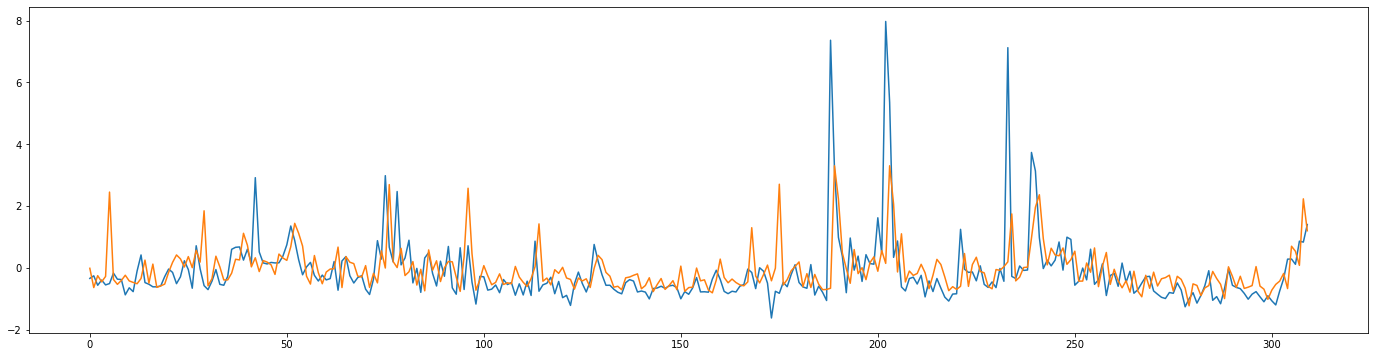

In [343]:
plt.figure(figsize=(24,6))
plt.plot(test_target.values)
#plt.plot(prediction_test)
plt.plot(preds)

In [344]:
mean_squared_error(test_target, preds)

1.1174576398527896

# arima

In [354]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [355]:
result = adfuller(target[:].values.T[0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.592569
p-value: 0.000000


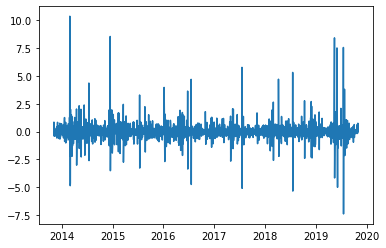

In [356]:
plt.plot(target.diff())

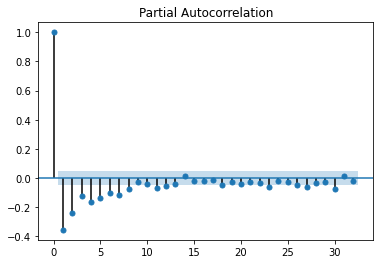

In [357]:
pacf = plot_pacf(target.diff(1)[1:])

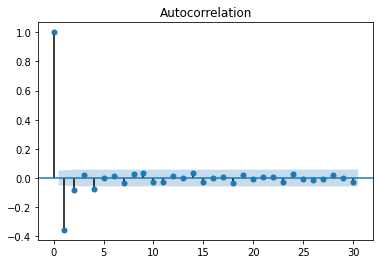

In [358]:
acf = plot_acf(target.diff()[1:], lags=30)

In [359]:
model = ARIMA(target, order=(7,1,2))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [360]:
prediction = model_fit.predict(start=len(target)-310, end=len(target))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


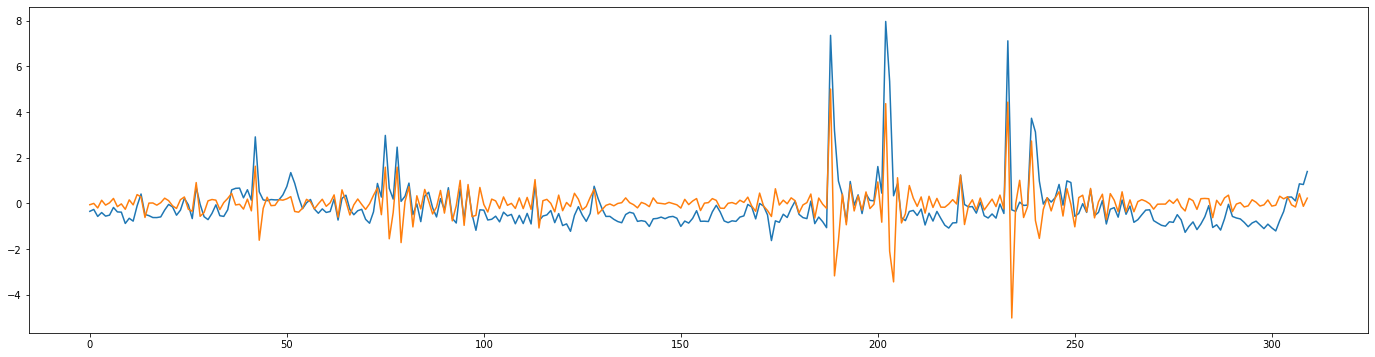

In [361]:
f = plot_preds(prediction.diff(-1)[:-1].values, test_target.values)

In [362]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#print('previous item baseline MSE |', mean_squared_error(test_target.values, test_dataset.X[:, 0]))
print('prediction MSE             |', mean_squared_error(test_target, prediction.diff(-1)[:-1].values))

prediction MSE             | 0.9921818470393031
